The objective of this update is to build a suite of simulated realizations of the asset to represent subsurface uncertainty.

1. Simulate 20 realizations of facies.
2. Simulate 20 realizations of porosity by-facies. Use trend model with
trend and residual workflow.
3. Cosimulate 20 realizations of permeability by facies.
4. Check the input statistics (histograms and variograms). For gam
calculations find an angle in cell offsets closest to major and minor.
5. Combine the porosity and permeability by-facies with the cookie
cutter approach.

# 1. Import packages and load dataset



In [110]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python      
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import random
import math
import scipy.signal as signal  

In [111]:
df = pd.read_csv('8_sample_data.csv')     # load our data table

Plotting parameters

In [112]:
pormin = 0.05; pormax = 0.25
permmin = 0.01; permmax = 1000;                # user specified min and max
AImin = 1000.0; AImax = 6000
Fmin = 0; Fmax = 1

xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
pormin = 0.05; pormax = 0.25
permmin = 0.01; permmax = 300;                # user specified min and max
AImin = 1000.0; AImax = 6000
Fmin = 0; Fmax = 1
cmap = plt.cm.plasma                    # color map

In [113]:
nx = 100; ny = 100; csize = 10.0
xsiz = 10; ysiz = 10
xmn = 5; ymn = 5

In [114]:
df['logPerm'] = np.log(df['Perm'].values)

In [115]:
df.describe()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,logPerm
count,168.000000,168.000000,168.00000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,207.767857,514.345238,465.87500,0.666667,0.153916,77.403572,3396.279944,2.407377
std,114.277788,290.006483,286.99991,0.472814,0.034007,202.949762,748.991891,2.299734
min,3.000000,0.000000,20.00000,0.000000,0.080884,0.046707,1189.857907,-3.063857
25%,104.000000,260.000000,209.00000,0.000000,0.130374,2.889615,2923.281779,1.060944
50%,216.500000,490.000000,439.50000,1.000000,0.150119,12.088688,3456.145034,2.492266
75%,306.750000,780.000000,729.00000,1.000000,0.177243,65.522793,3957.836990,4.179527
max,381.000000,990.000000,979.00000,1.000000,0.249454,2056.729133,5186.291314,7.628872


In [116]:
df_sand = pd.DataFrame.copy(df[df['Facies'] == 1]).reset_index()  # copy only 'Facies' = sand records
df_shale = pd.DataFrame.copy(df[df['Facies'] == 0]).reset_index() # copy only 'Facies' = shale records

In [117]:
df_sand.describe()

,index,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,logPerm
count,112.000000,112.000000,112.000000,112.000000,112.0,112.000000,112.000000,112.000000,112.000000
mean,81.035714,201.937500,516.428571,408.142857,1.0,0.165880,110.068496,3109.814779,3.146478
std,48.390106,113.631955,276.984590,278.284832,0.0,0.032048,241.522616,693.915972,2.053242
min,1.000000,5.000000,0.000000,20.000000,1.0,0.083737,0.156970,1189.857907,-1.851699
25%,40.750000,102.000000,297.500000,160.000000,1.0,0.143944,4.987704,2584.387646,1.602526
50%,76.500000,198.000000,490.000000,369.500000,1.0,0.166589,27.870215,3223.929842,3.327339
75%,124.500000,305.250000,770.000000,634.250000,1.0,0.186953,114.014701,3597.645230,4.736313
max,167.000000,381.000000,980.000000,979.000000,1.0,0.249454,2056.729133,4536.067943,7.628872


In [118]:
df_shale.describe()

,index,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,logPerm
count,56.000000,56.000000,56.000000,56.000000,56.0,56.000000,56.000000,56.000000,56.000000
mean,88.428571,219.428571,510.178571,581.339286,0.0,0.129989,12.073724,3969.210274,0.929176
std,49.205268,115.698960,317.028769,271.012061,0.0,0.023757,28.605079,479.840085,2.052602
min,0.000000,3.000000,60.000000,20.000000,0.0,0.080884,0.046707,2851.868733,-3.063857
25%,42.500000,107.000000,180.000000,439.750000,0.0,0.114131,0.424355,3681.067809,-0.857292
50%,97.000000,247.000000,500.000000,650.000000,0.0,0.128121,3.894984,3957.468966,1.358185
75%,125.500000,308.500000,840.000000,781.500000,0.0,0.142070,9.739336,4261.175382,2.275577
max,166.000000,380.000000,990.000000,979.000000,0.0,0.202176,188.228096,5186.291314,5.237655


# 2. Facies simulation

In [119]:
facies_grid = GSLIB.DataFrame2ndarray(df,'X','Y','Facies',xmin, xmax, ymin, ymax, csize)

We have made a kernel of size, number of grid cells (ny, nx) (53, 53)


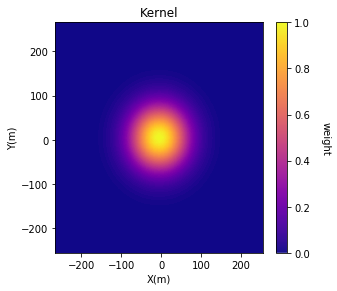

In [120]:
gkern1d = signal.gaussian(53,5).reshape(53, 1)
gkern2d = np.outer(gkern1d, gkern1d)
print('We have made a kernel of size, number of grid cells (ny, nx) ' + str(gkern2d.shape))

plt.subplot(111)
GSLIB.pixelplt_st(gkern2d,xmin=-265,xmax=265,ymin=-265,ymax=265,step=10,vmin=0,vmax=1,title='Kernel',xlabel='X(m)',ylabel='Y(m)',vlabel='weight',cmap=cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.6, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

In [121]:
import astropy.convolution.convolve as convolve
sand_trend = convolve(facies_grid,gkern2d,boundary='extend',nan_treatment='interpolate',normalize_kernel=True)

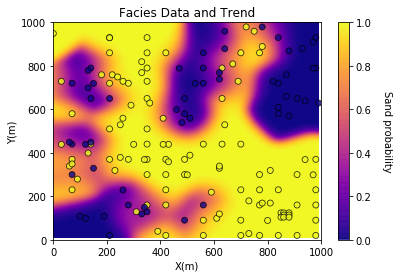

In [122]:
GSLIB.locpix_st(sand_trend,xmin,xmax,ymin,ymax,csize,0,1,df,'X','Y','Facies','Facies Data and Trend','X(m)','Y(m)','Sand probability',cmap)
plt.show()

In [123]:
facies_trend=np.zeros((np.shape(sand_trend)[0],np.shape(sand_trend)[1],2))
facies_trend[:,:,0] = 1-sand_trend; facies_trend[:,:,1] = sand_trend
facies_trend = geostats.correct_trend(facies_trend)

Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73073
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73074
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73075
   currently on node 0
   c

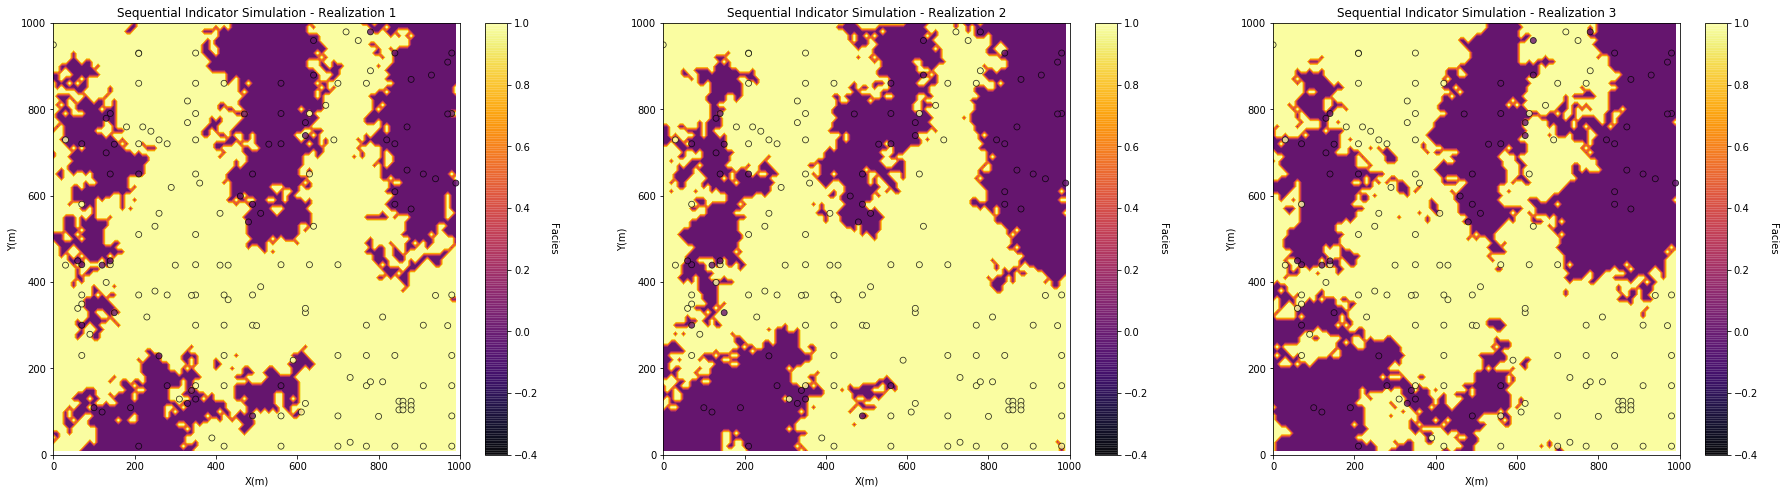

In [124]:
# Sequential Indicator Simulation with Simple Kriging Multiple Realizations 
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; nodmax = 10; radius = 400; skmean = 0
tmin = -999; tmax = 999

ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories
gcdf = [0.33,0.67]                           # the global proportions of the categories
varios_facies = []                                # the variogram list
varios_facies.append(GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.65,azi1=157.5,hmaj1=250,hmin1=250,it2=1,cc2=0.25,azi2=157.5,hmaj2=500,hmin2=500)) # shale indicator variogram
varios_facies.append(GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.65,azi1=157.5,hmaj1=250,hmin1=250,it2=1,cc2=0.25,azi2=157.5,hmaj2=500,hmin2=500)) # sand indicator variogram

num=20
sim_ik=[]
for i in range(num):
    sim_ik.append(geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf,trend=facies_trend,
               tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
               nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = 73073+i,
               ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,radius=radius,ktype=0,vario=varios_facies))



xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno # plotting parameters

plt.subplot(131)                                          # plot the results
GSLIB.locpix_st(sim_ik[0],xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 1','X(m)','Y(m)','Facies',cmap)

plt.subplot(132)                                          # plot the results
GSLIB.locpix_st(sim_ik[1],xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 2','X(m)','Y(m)','Facies',cmap)

plt.subplot(133)                                          # plot the results
GSLIB.locpix_st(sim_ik[2],xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 3','X(m)','Y(m)','Facies',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()



# 3. Simulate 20 realizations of porosity by-facies. Use trend model with trend and residual workflow.

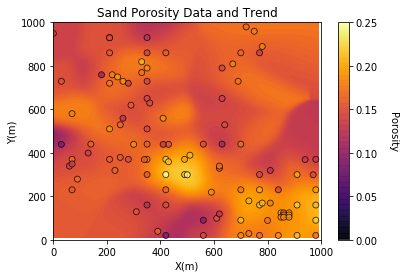

In [125]:
por_sand_grid = GSLIB.DataFrame2ndarray(df_sand,'X','Y','Porosity',xmin, xmax, ymin, ymax, csize)
por_sand_trend = convolve(por_sand_grid,gkern2d,boundary='extend',nan_treatment='interpolate',normalize_kernel=True)
GSLIB.locpix_st(por_sand_trend,xmin,xmax,ymin,ymax,csize,0,0.25,df_sand,'X','Y','Porosity','Sand Porosity Data and Trend','X(m)','Y(m)','Porosity',cmap)
plt.show()

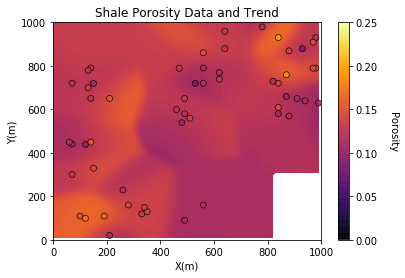

In [126]:
por_shale_grid = GSLIB.DataFrame2ndarray(df_shale,'X','Y','Porosity',xmin, xmax, ymin, ymax, csize)
por_shale_trend = convolve(por_shale_grid,gkern2d,boundary='extend',nan_treatment='interpolate',normalize_kernel=True)
GSLIB.locpix_st(por_shale_trend,xmin,xmax,ymin,ymax,csize,0,0.25,df_shale,'X','Y','Porosity','Shale Porosity Data and Trend','X(m)','Y(m)','Porosity',cmap)
plt.show()

In [127]:
df_sand = GSLIB.sample(por_sand_trend,xmin,ymin,csize,"Por_Trend",df_sand,'X','Y')
df_sand['Por_Res'] = df_sand['Porosity'] - df_sand['Por_Trend'] # calculate the residual and add to DataFrame

In [128]:
df_shale = GSLIB.sample(por_shale_trend,xmin,ymin,csize,"Por_Trend",df_shale,'X','Y')
df_shale['Por_Res'] = df_shale['Porosity'] - df_shale['Por_Trend'] # calculate the residual and add to DataFrame

In [129]:
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 50; ktype = 0; skmean = 0
por_sand_vario = GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.6,azi1=120,hmaj1=200,hmin1=100,it2=1,cc2=0.3,azi2=120,hmaj2=650,hmin2=200) # porosity sand variogram
por_shale_vario = GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.6,azi1=120,hmaj1=200,hmin1=100,it2=1,cc2=0.3,azi2=120,hmaj2=650,hmin2=200) # porosity shale variogram
tmin = -999; tmax = 999

por_sand_sim=[]
por_shale_sim=[]
for i in range(num):
    por_sand_sim.append(geostats.sgsim(df_sand,'X','Y','Por_Res',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=60000+i,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=por_sand_vario)+por_sand_trend)
    por_shale_sim.append(geostats.sgsim(df_shale,'X','Y','Por_Res',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=70000+i,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=por_shale_vario)+por_shale_trend)



 Data for SGSIM: Number of acceptable data     = 112
                 Number trimmed                = 0
                 Weighted Average              = -0.0005
                 Weighted Variance             = 0.0003
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9887
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0115 (close to 0.0?)
                                   variance = 0.71 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
       

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0848 (close to 0.0?)
                                   variance = 0.7008 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 112
                 Number trimmed                = 0
                 Weighted Average              = -0.0005
                 Weighted Variance             = 0.0003
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9887
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   c

   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0525 (close to 0.0?)
                                   variance = 0.7154 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.0005
                 Weighted Variance             = 0.0003
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0038 (close to 0.0?)
                                   variance = 0.8107 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.0005
                 Weighted Variance             = 0.0003
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curre

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0623 (close to 0.0?)
                                   variance = 0.7354 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 112
                 Number trimmed                = 0
                 Weighted Average              = -0.0005
                 Weighted Variance             = 0.0003
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9887
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                       

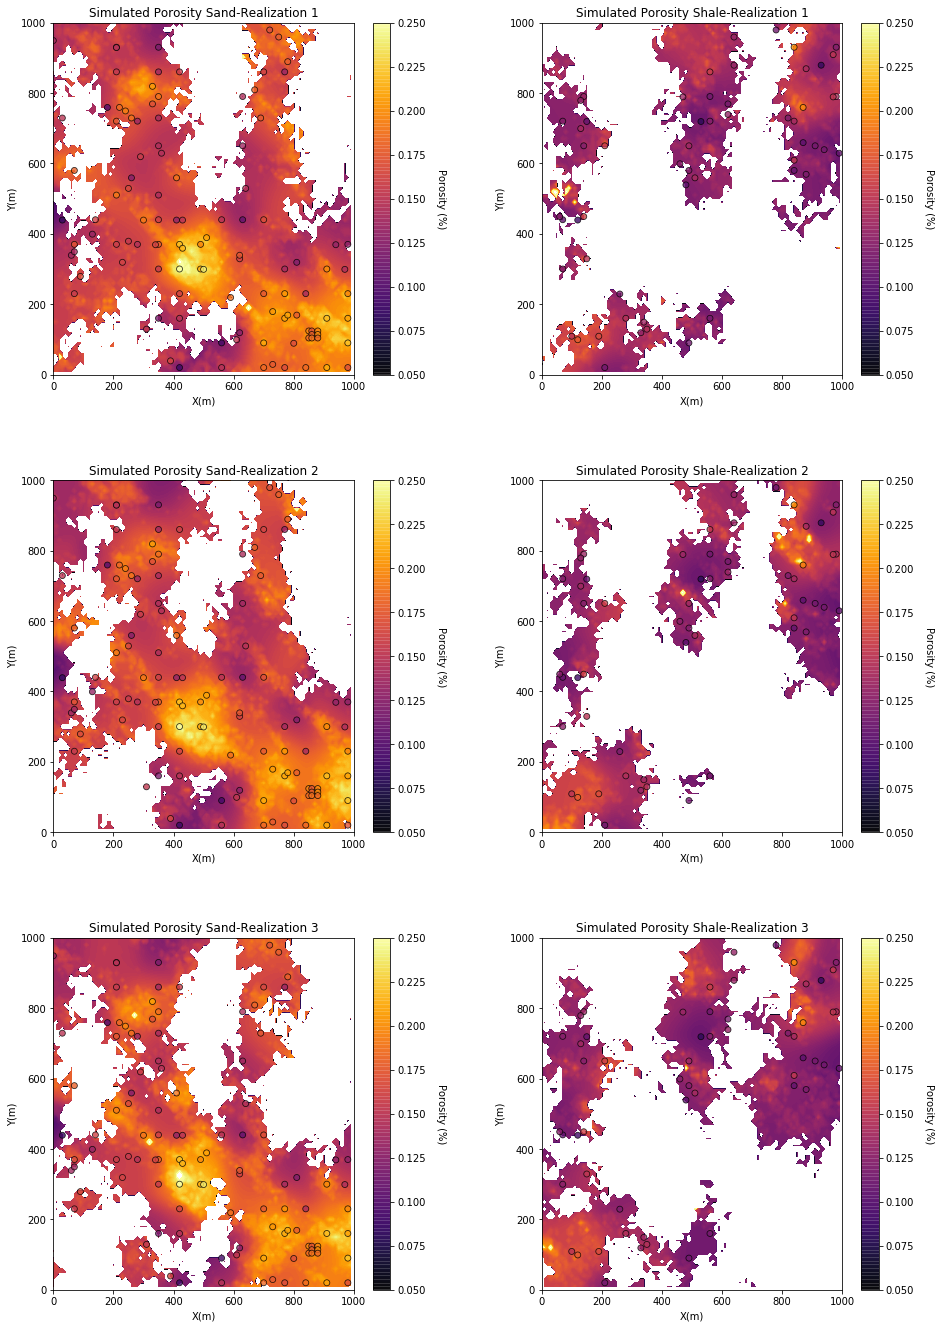

In [130]:
por_sim=[]
from copy import deepcopy
por_sand_sim_old=deepcopy(por_sand_sim)  #storing for future use
por_shale_sim_old=deepcopy(por_shale_sim) #storing for future use

for i in range(num):
    por_sim_temp=np.zeros((ny,nx))
    for iy in range(0,ny):
        for ix in range(0,nx):
            if sim_ik[i][iy,ix] ==1:   # current location is assumed to be sand     
                por_sim_temp[iy,ix] = por_sand_sim[i][iy,ix];    
                por_shale_sim[i][iy,ix] = -1
            else:                      # current location is assumed to be shale
                por_sim_temp[iy,ix] = por_shale_sim[i][iy,ix];
                por_sand_sim[i][iy,ix] = -1
    por_sim.append(por_sim_temp)

plt.subplot(321)
GSLIB.locpix_st(por_sand_sim[0],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df_sand,'X','Y','Porosity','Simulated Porosity Sand-Realization 1','X(m)','Y(m)','Porosity (%)',cmap)
plt.subplot(322)
GSLIB.locpix_st(por_shale_sim[0],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df_shale,'X','Y','Porosity','Simulated Porosity Shale-Realization 1','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(323)
GSLIB.locpix_st(por_sand_sim[1],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df_sand,'X','Y','Porosity','Simulated Porosity Sand-Realization 2','X(m)','Y(m)','Porosity (%)',cmap)
plt.subplot(324)
GSLIB.locpix_st(por_shale_sim[1],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df_shale,'X','Y','Porosity','Simulated Porosity Shale-Realization 2','X(m)','Y(m)','Porosity (%)',cmap)


plt.subplot(325)
GSLIB.locpix_st(por_sand_sim[2],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df_sand,'X','Y','Porosity','Simulated Porosity Sand-Realization 3','X(m)','Y(m)','Porosity (%)',cmap)
plt.subplot(326)
GSLIB.locpix_st(por_shale_sim[2],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df_shale,'X','Y','Porosity','Simulated Porosity Shale-Realization 3','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.4, wspace=0.3, hspace=0.3)
plt.show()

# 4. Cosimulate permeability

In [131]:
ns_por_sand,_,_ = geostats.nscore(df_sand,'Porosity')
ns_perm_sand,_,_ = geostats.nscore(df_sand,'Perm')
ns_por_shale,_,_ = geostats.nscore(df_shale,'Porosity')
ns_perm_shale,_,_ = geostats.nscore(df_shale,'Perm')

In [132]:
pearson_r_sand=stats.pearsonr(ns_por_sand, ns_perm_sand)[0]
pearson_r_shale=stats.pearsonr(ns_por_shale, ns_perm_shale)[0]

In [133]:
print("correlation coefficient for sand is: "+ str(pearson_r_sand))
print("correlation coefficient for shale is: "+ str(pearson_r_shale))

correlation coefficient for sand is: 0.2601344953325654
correlation coefficient for shale is: -0.13431668766705476


In [134]:
perm_sand_vario = GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.6,azi1=70,hmaj1=400,hmin1=90,it2=1,cc2=0.3,azi2=70,hmaj2=750,hmin2=300) # perm sand variogram
perm_shale_vario = GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.6,azi1=70,hmaj1=400,hmin1=90,it2=1,cc2=0.3,azi2=70,hmaj2=750,hmin2=300) # perm shale variogram

df_sand['logPerm'] = np.log(df_sand['Perm'].values)
df_shale['logPerm'] = np.log(df_shale['Perm'].values)

nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 100; 
tmin = -99999; tmax = 99999


perm_sand_sim=[]
perm_shale_sim=[]
sim_log_perm_sand=[]
sim_log_perm_shale=[]
for i in range(num):
    perm_sand_sim.append(geostats.sgsim(df_sand,'X','Y','Perm',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=1000.0,ltail=1,ltpar=0.0,utail=1,utpar=1000.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=40000+i,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=4,colocorr=pearson_r_sand,sec_map=por_sand_sim_old[i],vario=perm_sand_vario))
    perm_shale_sim.append(geostats.sgsim(df_shale,'X','Y','Perm',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=200.0,ltail=1,ltpar=0.0,utail=1,utpar=200.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=30000+i,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=4,colocorr=pearson_r_shale,sec_map=por_shale_sim_old[i],vario=perm_shale_vario))
    
for i in range(num):
    sim_log_perm_sand.append(np.log(perm_sand_sim[i].clip(0.0001,3200)))
    sim_log_perm_shale.append(np.log(perm_shale_sim[i].clip(0.0001,400)))




 Data for SGSIM: Number of acceptable data     = 112
                 Number trimmed                = 0
                 Weighted Average              = 110.0685
                 Weighted Variance             = 57812.3422
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9887
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.1642
                 Equal Weighted Variance    = 0.0004
 Transforming Secondary Data with
 variance reduction of 1.0
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     =

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0447 (close to 0.0?)
                                   variance = 0.6809 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 112
                 Number trimmed                = 0
                 Weighted Average              = 110.0685
                 Weighted Variance             = 57812.3422
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9887
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.1638
                 Equal Weighted Variance    = 0.0005
 Transforming Secondary Data with
 variance reduction 

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0066 (close to 0.0?)
                                   variance = 0.7889 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 112
                 Number trimmed                = 0
                 Weighted Average              = 110.0685
                 Weighted Variance             = 57812.3422
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9887
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.1637
                 Equal Weighted Variance    = 0.0005
 Transforming Secondary Data with
 variance reduction 

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0283 (close to 0.0?)
                                   variance = 0.8145 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 112
                 Number trimmed                = 0
                 Weighted Average              = 110.0685
                 Weighted Variance             = 57812.3422
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9887
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.1632
                 Equal Weighted Variance    = 0.0005
 Transforming Secondary Data with
 variance reduction 

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.1475 (close to 0.0?)
                                   variance = 0.8415 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 112
                 Number trimmed                = 0
                 Weighted Average              = 110.0685
                 Weighted Variance             = 57812.3422
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9887
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.164
                 Equal Weighted Variance    = 0.0005
 Transforming Secondary Data with
 variance reduction of

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0481 (close to 0.0?)
                                   variance = 0.8536 (close to gammabar(V,V)? approx. 1.0)


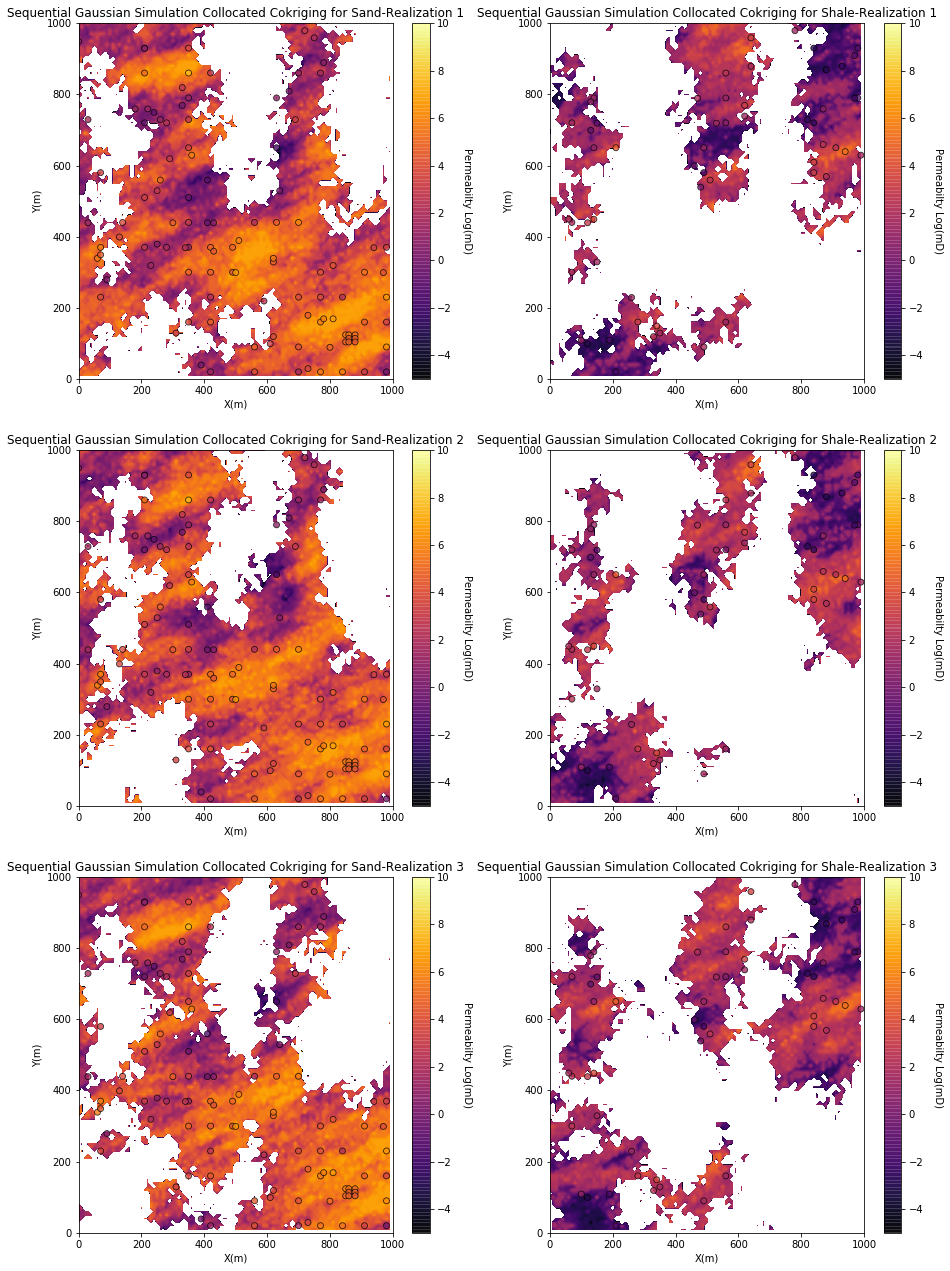

In [135]:
perm_sim=[]
perm_sand_sim_old=deepcopy(perm_sand_sim)  #storing for future use
perm_shale_sim_old=deepcopy(perm_shale_sim) #storing for future use
log_perm_sim=[]
log_perm_sand_sim_old=deepcopy(sim_log_perm_sand)  #storing for future use
log_perm_shale_sim_old=deepcopy(sim_log_perm_shale) #storing for future use
for i in range(num):
    perm_sim_temp=np.zeros((ny,nx))
    log_perm_sim_temp=np.zeros((ny,nx))
    for iy in range(0,ny):
        for ix in range(0,nx):
            if sim_ik[i][iy,ix] ==1:   # current location is assumed to be sand     
                perm_sim_temp[iy,ix] = perm_sand_sim[i][iy,ix];    
                perm_shale_sim[i][iy,ix] = -1
                log_perm_sim_temp[iy,ix] = sim_log_perm_sand[i][iy,ix];    
                sim_log_perm_shale[i][iy,ix]=-100
            else:                      # current location is assumed to be shale
                perm_sim_temp[iy,ix] = perm_shale_sim[i][iy,ix];
                perm_sand_sim[i][iy,ix] = -1
                log_perm_sim_temp[iy,ix] = sim_log_perm_shale[i][iy,ix];    
                sim_log_perm_sand[i][iy,ix]=-100
    perm_sim.append(perm_sim_temp)
    log_perm_sim.append(log_perm_sim_temp)
    
    
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(321)
GSLIB.locpix_st(sim_log_perm_sand[0],xmin,xmax,ymin,ymax,xsiz,-5.0,10,df_sand,'X','Y','logPerm','Sequential Gaussian Simulation Collocated Cokriging for Sand-Realization 1','X(m)','Y(m)','Permeabilty Log(mD)',cmap)
plt.subplot(322)
GSLIB.locpix_st(sim_log_perm_shale[0],xmin,xmax,ymin,ymax,xsiz,-5.0,10,df_shale,'X','Y','logPerm','Sequential Gaussian Simulation Collocated Cokriging for Shale-Realization 1','X(m)','Y(m)','Permeabilty Log(mD)',cmap)

plt.subplot(323)
GSLIB.locpix_st(sim_log_perm_sand[1],xmin,xmax,ymin,ymax,xsiz,-5.0,10,df_sand,'X','Y','logPerm','Sequential Gaussian Simulation Collocated Cokriging for Sand-Realization 2','X(m)','Y(m)','Permeabilty Log(mD)',cmap)
plt.subplot(324)
GSLIB.locpix_st(sim_log_perm_shale[1],xmin,xmax,ymin,ymax,xsiz,-5.0,10,df_shale,'X','Y','logPerm','Sequential Gaussian Simulation Collocated Cokriging for Shale-Realization 2','X(m)','Y(m)','Permeabilty Log(mD)',cmap)

plt.subplot(325)
GSLIB.locpix_st(sim_log_perm_sand[2],xmin,xmax,ymin,ymax,xsiz,-5.0,10,df_sand,'X','Y','logPerm','Sequential Gaussian Simulation Collocated Cokriging for Sand-Realization 3','X(m)','Y(m)','Permeabilty Log(mD)',cmap)
plt.subplot(326)
GSLIB.locpix_st(sim_log_perm_shale[2],xmin,xmax,ymin,ymax,xsiz,-5.0,10,df_shale,'X','Y','logPerm','Sequential Gaussian Simulation Collocated Cokriging for Shale-Realization 3','X(m)','Y(m)','Permeabilty Log(mD)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.2)
plt.show()

# 5. Check input statistics

To calculate sample statistics, declustering need to be conducted. For each statistics, the first 3 realizations were used to calculate simulation statistics. The sample histogram was weighted using declustering weight for porosity 

First check for facies histogram and variogram. 

## Facies

In [136]:
print("declustering porosity:")
wts_porosity, cell_sizes, dmeans = geostats.declus(df,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df['Wts_porosity'] = wts_porosity # add weights to the sample data DataFrame

declustering porosity:
There are 168 data with:
   mean of      0.15391629523632155 
   min and max  0.0808837694350806 and 0.2494536799448483
   standard dev 0.033906041125275496 


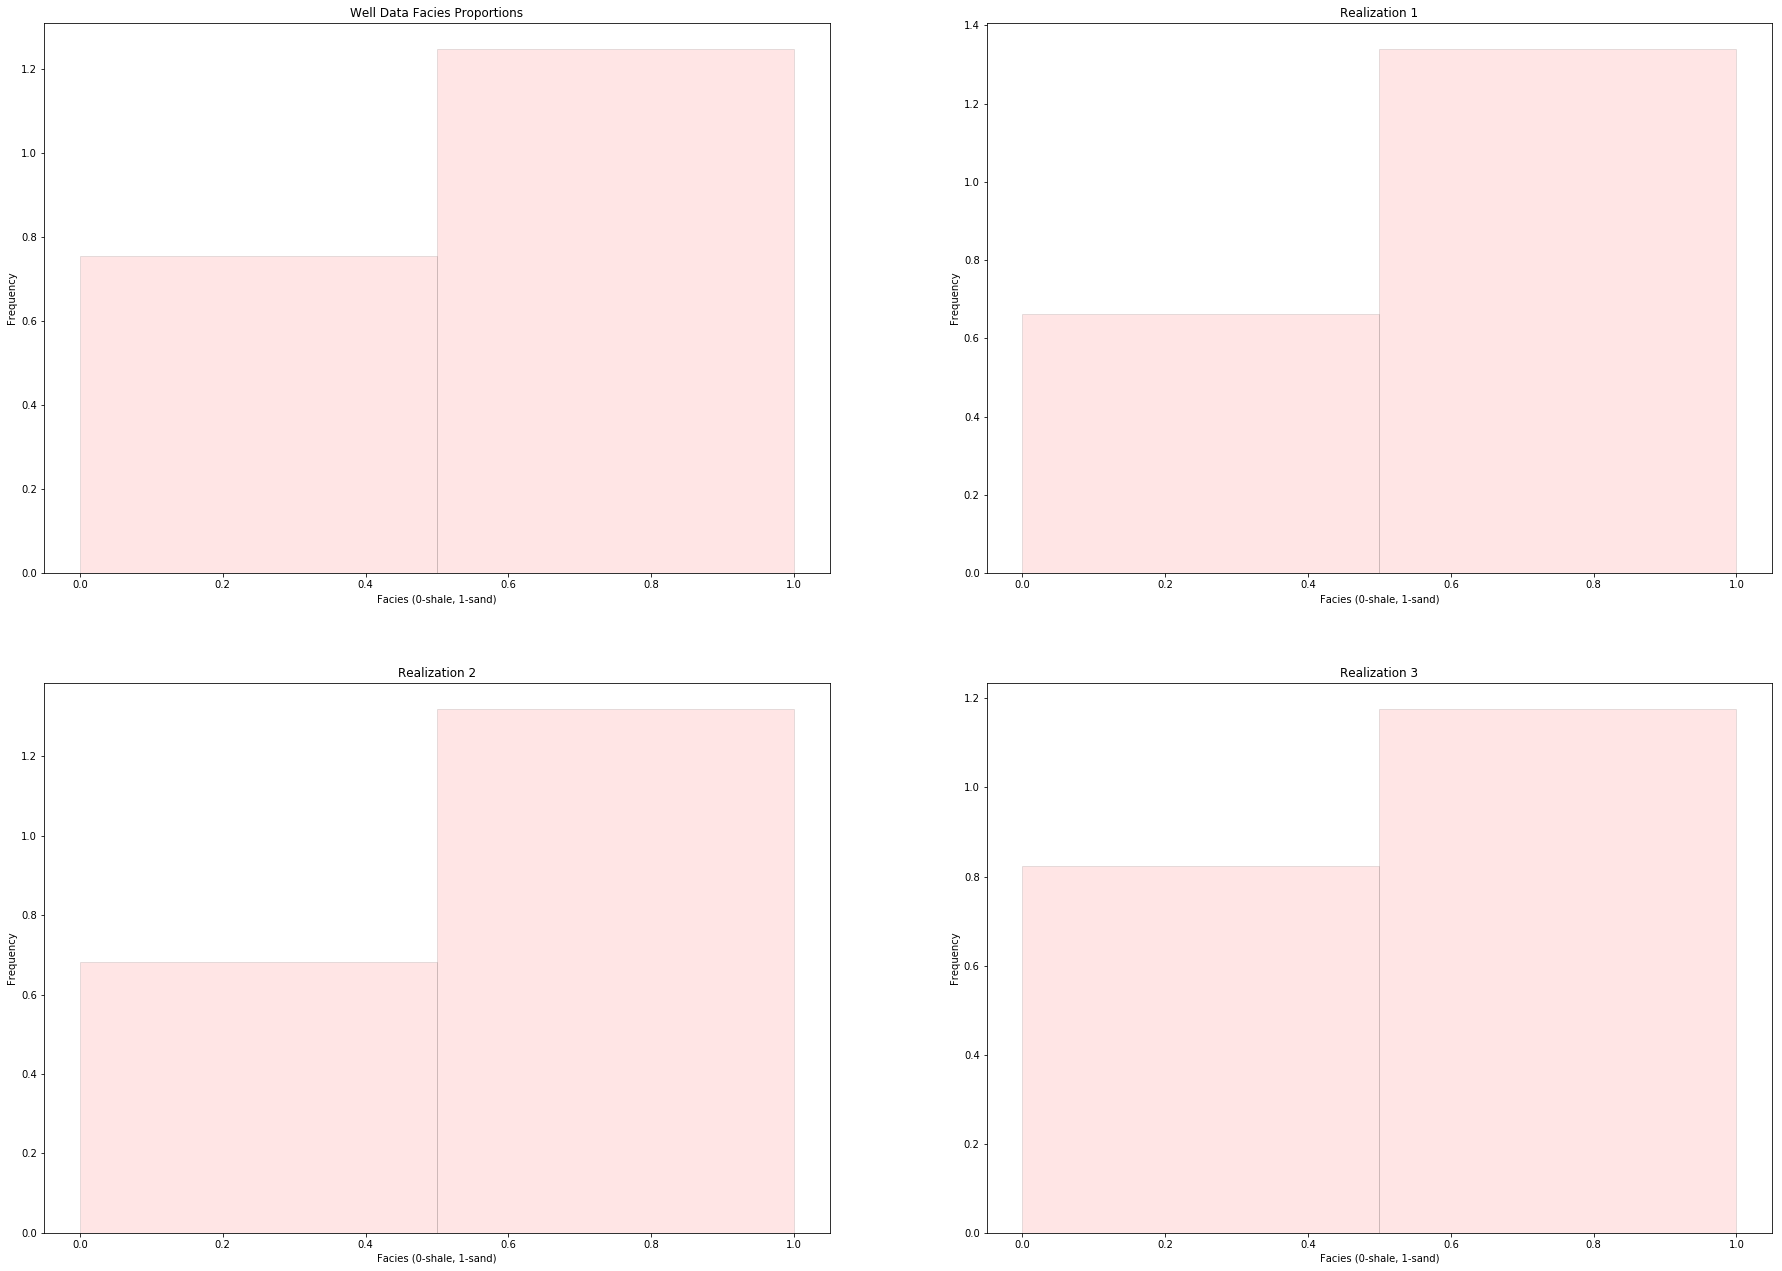

In [137]:
plt.subplot(221)
plt.hist(df['Facies'].values,bins=2,density=True,weights=df['Wts_porosity'].values,cumulative = False,alpha=0.1,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Well Data Facies Proportions')
plt.ylabel('Frequency')
plt.subplot(222)
plt.hist(sim_ik[0].flatten(),bins=2,density=True,cumulative = False,alpha=0.1,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Realization 1')
plt.ylabel('Frequency')
plt.subplot(223)
plt.hist(sim_ik[1].flatten(),bins=2,density=True,cumulative = False,alpha=0.1,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Realization 2')
plt.ylabel('Frequency')
plt.subplot(224)
plt.hist(sim_ik[2].flatten(),bins=2,density=True,cumulative = False,alpha=0.1,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Realization 3')
plt.ylabel('Frequency')


plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=4.2, wspace=0.2, hspace=0.2)
plt.show()


To calculate directional variogram from simulation. Offset direction closest to major and minor direction need to be found. Note that for the simulated grid takes the form [iy,ix] and the 'iy' index increase in the direction of decreasing y axis. Also note that the direction of azimuth is taken in clockwise direction starting from North.

For 157.5 degrees, closest x and y offsets are 2 and 5. For 67.5 degrees, closest x and y offsets are 5 and -2. 

In [138]:
nlag = 70; xlag = 10; azm = 67.5; 
index1,h1,gam1,cov1,ro1 = geostats.vmodel(nlag,xlag,azm,varios_facies[0])
azm = 157.5
index2,h2,gam2,cov2,ro2 = geostats.vmodel(nlag,xlag,azm,varios_facies[0])
index=[index1,index2]
h=[h1,h2]
gamma=[gam1,gam2]

tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 100.0; lag_tol = 100.0; nlag = 7;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [67.5,157.5]           # directions in azimuth to consider
# Arrays to store the results
lag_sand = np.zeros((len(azi_mat),nlag+2)); gamma_sand = np.zeros((len(azi_mat),nlag+2)); npp_sand = np.zeros((len(azi_mat),nlag+2));


for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag_sand[iazi,:], gamma_sand[iazi,:], npp_sand[iazi,:] = geostats.gamv(df,"X","Y","Facies",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    
nlag = 10
xsiz=10.0
ysiz=10.0
lag_sand_sim_combined=[]
gamma_sand_sim_combined=[]
npp_sand_sim_combined=[]    

for i in range(3):
    lag_sand_sim = np.zeros((len(azi_mat),nlag)); gamma_sand_sim = np.zeros((len(azi_mat),nlag)); npp_sand_sim = np.zeros((len(azi_mat),nlag));
    lag_sand_sim[0,:], gamma_sand_sim[0,:], npp_sand_sim[0,:] = geostats.gam(sim_ik[i],tmin,tmax,xsiz,ysiz,5,-2,nlag,isill)
    lag_sand_sim[1,:], gamma_sand_sim[1,:], npp_sand_sim[1,:] = geostats.gam(sim_ik[i],tmin,tmax,xsiz,ysiz,2,5,nlag,isill)
    lag_sand_sim_combined.append(lag_sand_sim)
    gamma_sand_sim_combined.append(gamma_sand_sim)
    npp_sand_sim_combined.append(npp_sand_sim)
    

 x,y,z offsets = 9.238795319961289,3.826834336087908
 x,y,z offsets = 3.82683435267059,-9.238795313092517


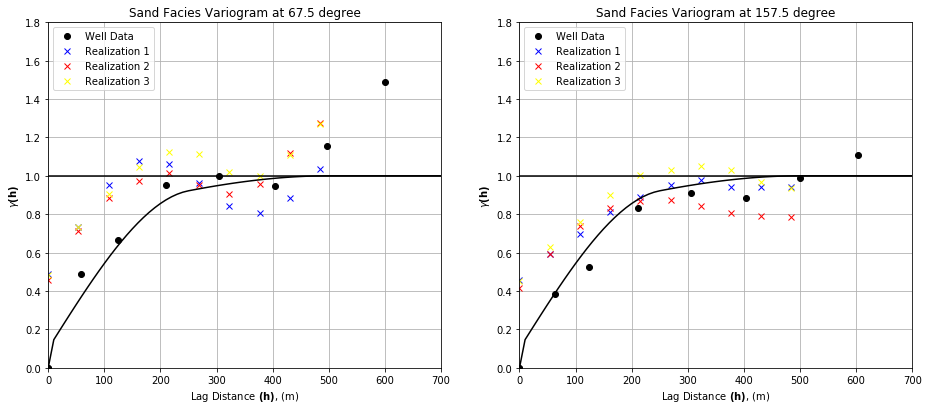

In [139]:
for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    plt.subplot(1,2,iazi+1)
    plt.plot(lag_sand[iazi,:],gamma_sand[iazi,:],'o',color = 'black',label = 'Well Data')
    plt.plot(lag_sand_sim_combined[0][iazi,:],gamma_sand_sim_combined[0][iazi,:],'x',color = 'blue',label = 'Realization 1')
    plt.plot(lag_sand_sim_combined[1][iazi,:],gamma_sand_sim_combined[1][iazi,:],'x',color = 'red',label = 'Realization 2')
    plt.plot(lag_sand_sim_combined[2][iazi,:],gamma_sand_sim_combined[2][iazi,:],'x',color = 'yellow',label = 'Realization 3')
    plt.plot(h[iazi],gamma[iazi],color = 'black')
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Sand Facies Variogram at '+str(azi_mat[iazi])+' degree')
    plt.xlim([0,700])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

## Porosity

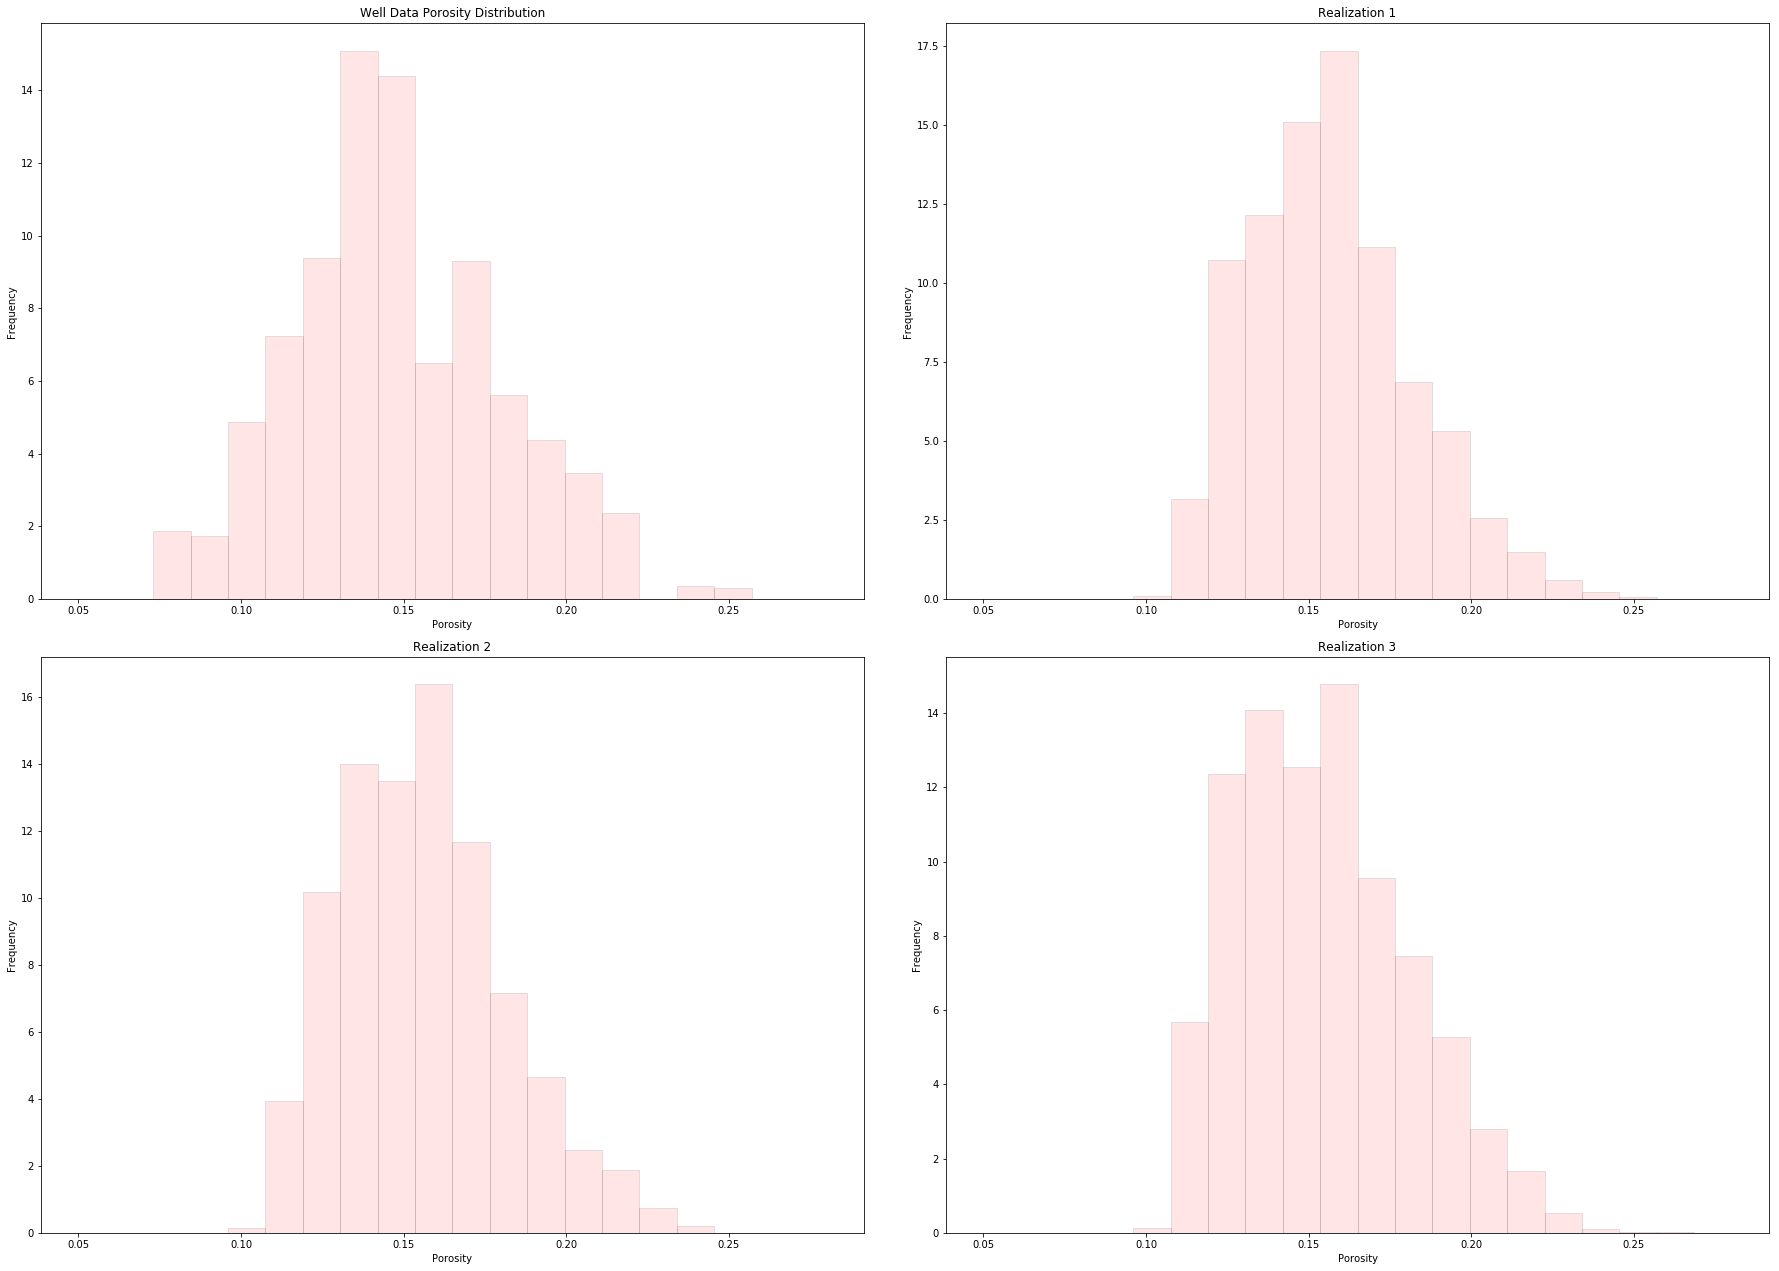

In [140]:
plt.subplot(221)
plt.hist(df['Porosity'].values,bins=20,range=(0.05,0.28),density=True,weights=df['Wts_porosity'].values,cumulative = False,alpha=0.1,color='red',edgecolor='black')
plt.xlabel('Porosity')
plt.title('Well Data Porosity Distribution')
plt.ylabel('Frequency')
plt.subplot(222)
plt.hist(por_sim[0].flatten(),bins=20,range=(0.05,0.28),density=True,cumulative = False,alpha=0.1,color='red',edgecolor='black')
plt.xlabel('Porosity')
plt.title('Realization 1')
plt.ylabel('Frequency')
plt.subplot(223)
plt.hist(por_sim[1].flatten(),bins=20,range=(0.05,0.28),density=True,cumulative = False,alpha=0.1,color='red',edgecolor='black')
plt.xlabel('Porosity')
plt.title('Realization 2')
plt.ylabel('Frequency')
plt.subplot(224)
plt.hist(por_sim[2].flatten(),bins=20,range=(0.05,0.28),density=True,cumulative = False,alpha=0.1,color='red',edgecolor='black')
plt.xlabel('Porosity')
plt.title('Realization 3')
plt.ylabel('Frequency')


plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=4.2, wspace=0.1, hspace=0.1)
plt.show()

For 120 degrees, closest x and y offsets are 2 and 4. For 30 degrees, closest x and y offsets are 4 and -2. 

In [141]:
nlag = 70; xlag = 10; azm = 30; 
index1,h1,gam1,cov1,ro1 = geostats.vmodel(nlag,xlag,azm,varios_facies[0])
azm = 120
index2,h2,gam2,cov2,ro2 = geostats.vmodel(nlag,xlag,azm,varios_facies[0])
index=[index1,index2]
h=[h1,h2]
gamma=[gam1,gam2]


tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 100.0; lag_tol = 100.0; nlag = 7;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [30,120]           # directions in azimuth to consider
# Arrays to store the results
lag_por = np.zeros((len(azi_mat),nlag+2)); gamma_por = np.zeros((len(azi_mat),nlag+2)); npp_por = np.zeros((len(azi_mat),nlag+2));


for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag_por[iazi,:], gamma_por[iazi,:], npp_por[iazi,:] = geostats.gamv(df,"X","Y","Porosity",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    
nlag = 12
xsiz=10.0
ysiz=10.0
lag_por_sim_combined=[]
gamma_por_sim_combined=[]
npp_por_sim_combined=[]    

for i in range(3):
    lag_por_sim = np.zeros((len(azi_mat),nlag)); gamma_por_sim = np.zeros((len(azi_mat),nlag)); npp_por_sim = np.zeros((len(azi_mat),nlag));
    lag_por_sim[0,:], gamma_por_sim[0,:], npp_por_sim[0,:] = geostats.gam(por_sim[i],tmin,tmax,xsiz,ysiz,4,-2,nlag,isill)
    lag_por_sim[1,:], gamma_por_sim[1,:], npp_por_sim[1,:] = geostats.gam(por_sim[i],tmin,tmax,xsiz,ysiz,2,4,nlag,isill)
    lag_por_sim_combined.append(lag_por_sim)
    gamma_por_sim_combined.append(gamma_por_sim)
    npp_por_sim_combined.append(npp_por_sim)
    

 x,y,z offsets = 4.99999999481858,8.66025404083588
 x,y,z offsets = 8.660254049810362,-4.999999979274321


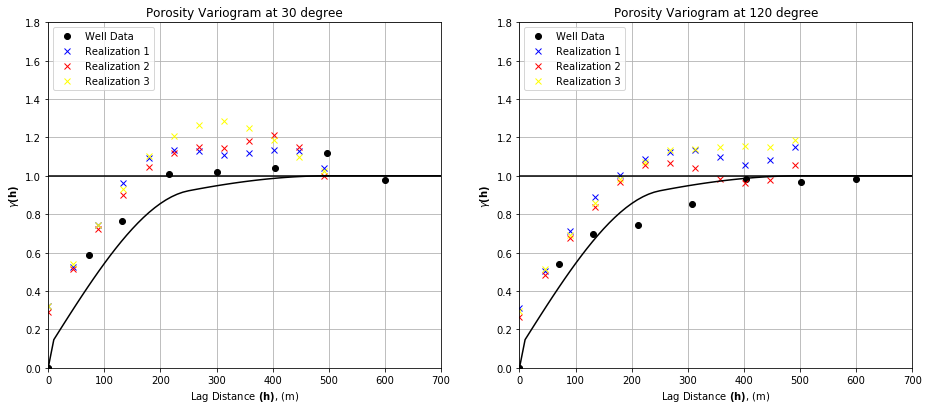

In [142]:
for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    plt.subplot(1,2,iazi+1)
    plt.plot(lag_por[iazi,:],gamma_por[iazi,:],'o',color = 'black',label = 'Well Data')
    plt.plot(lag_por_sim_combined[0][iazi,:],gamma_por_sim_combined[0][iazi,:],'x',color = 'blue',label = 'Realization 1')
    plt.plot(lag_por_sim_combined[1][iazi,:],gamma_por_sim_combined[1][iazi,:],'x',color = 'red',label = 'Realization 2')
    plt.plot(lag_por_sim_combined[2][iazi,:],gamma_por_sim_combined[2][iazi,:],'x',color = 'yellow',label = 'Realization 3')
    plt.plot(h[iazi],gamma[iazi],color = 'black')
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Porosity Variogram at '+str(azi_mat[iazi])+' degree')
    plt.xlim([0,700])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

## Permeability

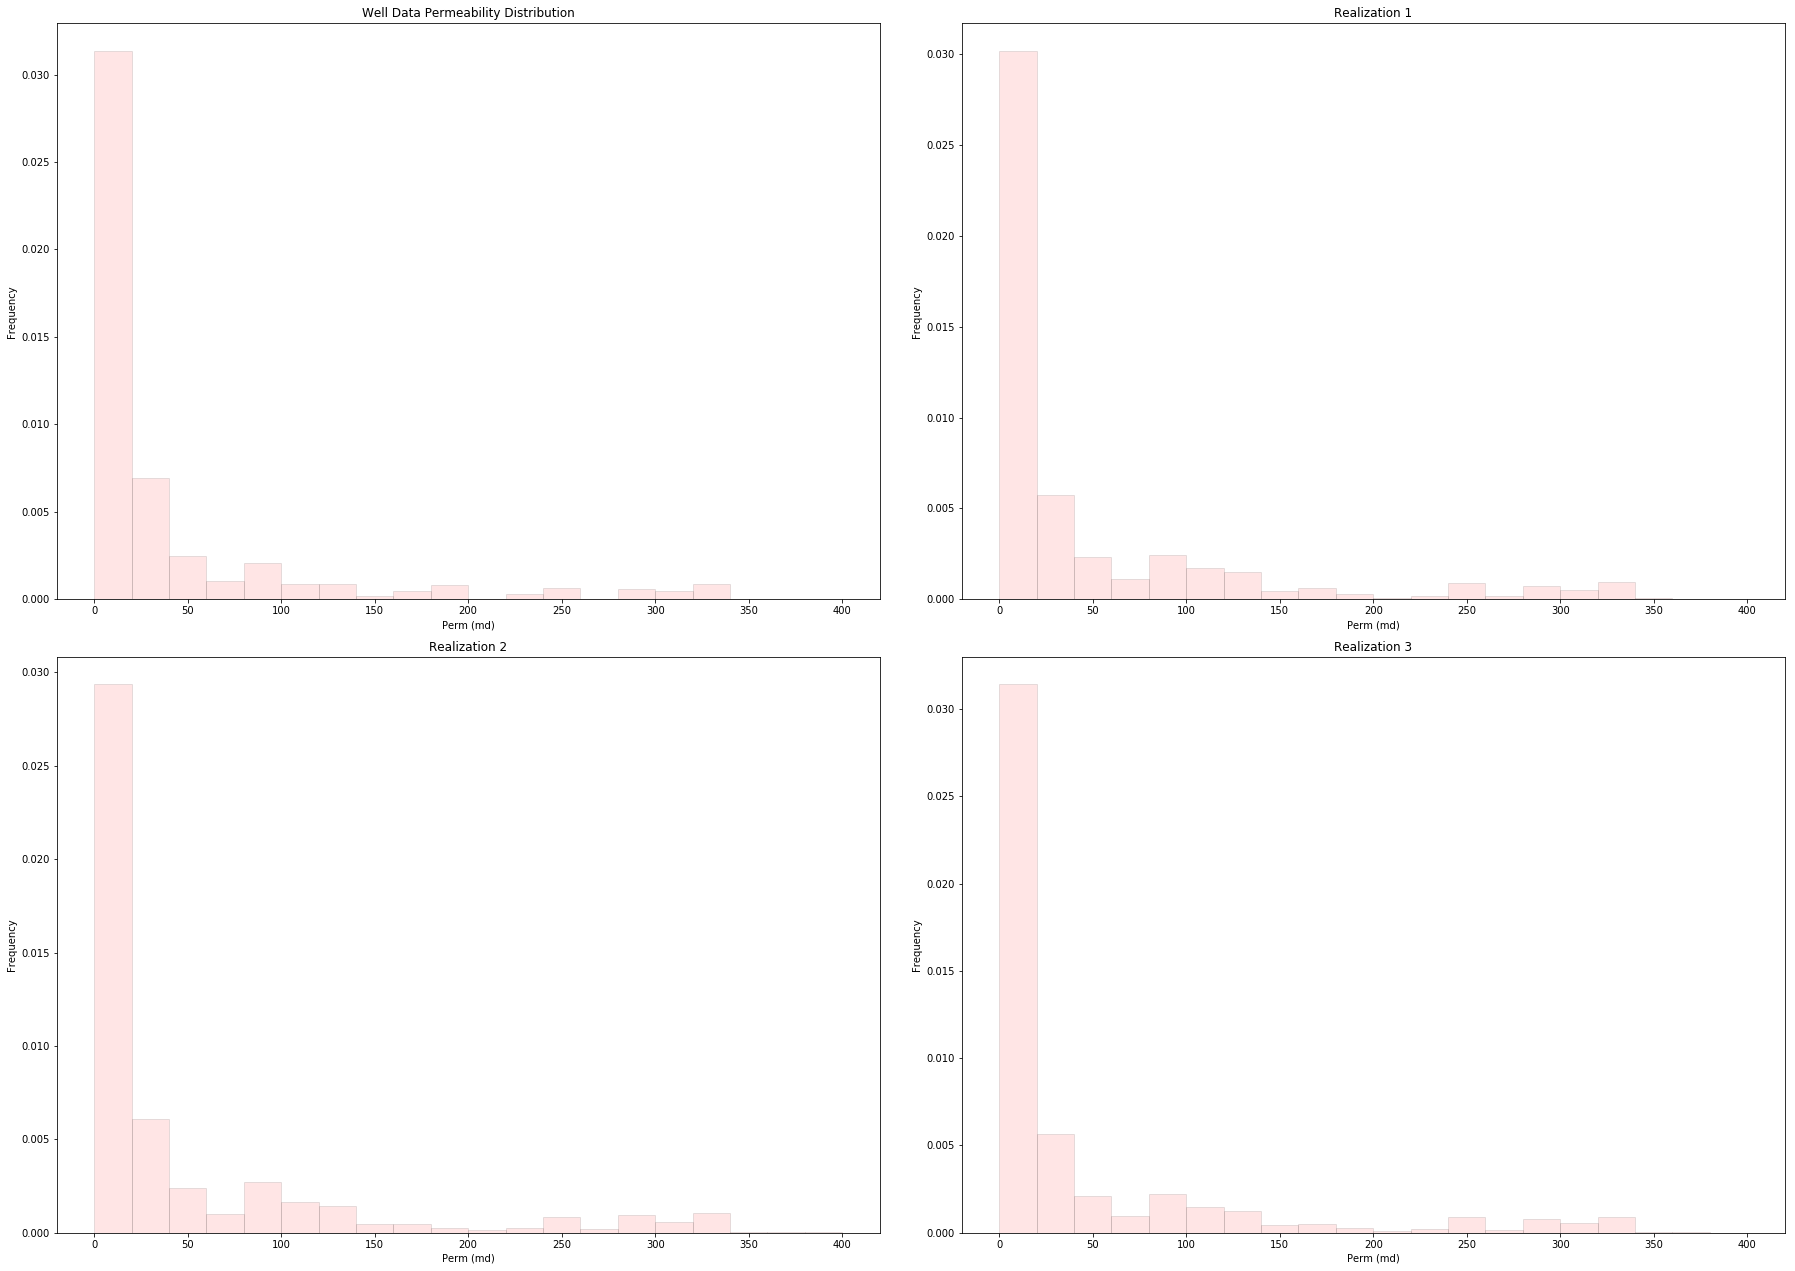

In [143]:
plt.subplot(221)
plt.hist(df['Perm'].values,bins=20,range=(0,400),density=True,weights=df['Wts_porosity'].values,cumulative = False,alpha=0.1,color='red',edgecolor='black')
plt.xlabel('Perm (md)')
plt.title('Well Data Permeability Distribution')
plt.ylabel('Frequency')
plt.subplot(222)
plt.hist(perm_sim[0].flatten(),bins=20,range=(0,400),density=True,cumulative = False,alpha=0.1,color='red',edgecolor='black')
plt.xlabel('Perm (md)')
plt.title('Realization 1')
plt.ylabel('Frequency')
plt.subplot(223)
plt.hist(perm_sim[1].flatten(),bins=20,range=(0,400),density=True,cumulative = False,alpha=0.1,color='red',edgecolor='black')
plt.xlabel('Perm (md)')
plt.title('Realization 2')
plt.ylabel('Frequency')
plt.subplot(224)
plt.hist(perm_sim[2].flatten(),bins=20,range=(0,400),density=True,cumulative = False,alpha=0.1,color='red',edgecolor='black')
plt.xlabel('Perm (md)')
plt.title('Realization 3')
plt.ylabel('Frequency')


plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=4.2, wspace=0.1, hspace=0.1)
plt.show()

For 70 degrees, closest x and y offsets are 5 and -2. For 160 degrees, closest x and y offsets are 2 and 5. 

In [144]:
nlag = 70; xlag = 10; azm = 70; 
index1,h1,gam1,cov1,ro1 = geostats.vmodel(nlag,xlag,azm,perm_sand_vario)
azm = 160
index2,h2,gam2,cov2,ro2 = geostats.vmodel(nlag,xlag,azm,perm_sand_vario)
index=[index1,index2]
h=[h1,h2]
gamma=[gam1,gam2]


tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 100.0; lag_tol = 100.0; nlag = 7;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [70,160]           # directions in azimuth to consider
# Arrays to store the results
lag_perm = np.zeros((len(azi_mat),nlag+2)); gamma_perm = np.zeros((len(azi_mat),nlag+2)); npp_perm = np.zeros((len(azi_mat),nlag+2));


for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag_perm[iazi,:], gamma_perm[iazi,:], npp_perm[iazi,:] = geostats.gamv(df,"X","Y","Perm",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    
nlag = 12
xsiz=10.0
ysiz=10.0
lag_perm_sim_combined=[]
gamma_perm_sim_combined=[]
npp_perm_sim_combined=[]    

for i in range(3):
    lag_perm_sim = np.zeros((len(azi_mat),nlag)); gamma_perm_sim = np.zeros((len(azi_mat),nlag)); npp_perm_sim = np.zeros((len(azi_mat),nlag));
    lag_perm_sim[0,:], gamma_perm_sim[0,:], npp_perm_sim[0,:] = geostats.gam(perm_sim[i],tmin,tmax,xsiz,ysiz,5,-2,nlag,isill)
    lag_perm_sim[1,:], gamma_perm_sim[1,:], npp_perm_sim[1,:] = geostats.gam(perm_sim[i],tmin,tmax,xsiz,ysiz,2,5,nlag,isill)
    lag_perm_sim_combined.append(lag_perm_sim)
    gamma_perm_sim_combined.append(gamma_perm_sim)
    npp_perm_sim_combined.append(npp_perm_sim)
    

 x,y,z offsets = 9.396926203084378,3.420201446375083
 x,y,z offsets = 3.420201463241595,-9.39692619694547


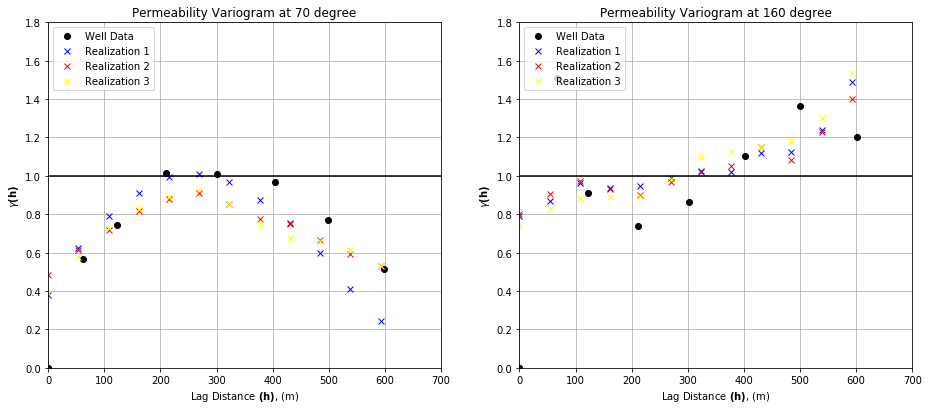

In [146]:
for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    plt.subplot(1,2,iazi+1)
    plt.plot(lag_perm[iazi,:],gamma_perm[iazi,:],'o',color = 'black',label = 'Well Data')
    plt.plot(lag_perm_sim_combined[0][iazi,:],gamma_perm_sim_combined[0][iazi,:],'x',color = 'blue',label = 'Realization 1')
    plt.plot(lag_perm_sim_combined[1][iazi,:],gamma_perm_sim_combined[1][iazi,:],'x',color = 'red',label = 'Realization 2')
    plt.plot(lag_perm_sim_combined[2][iazi,:],gamma_perm_sim_combined[2][iazi,:],'x',color = 'yellow',label = 'Realization 3')
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Permeability Variogram at '+str(azi_mat[iazi])+' degree')
    plt.xlim([0,700])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

# 6. Build a combined model (cookie cutter approach) at all locations.

The facies, porosity and log(permeability) for combined model are stored in `sim_ik`, `por_sim` and `log_perm_sim` respectively. Results from the first 3 realizations are plotted.

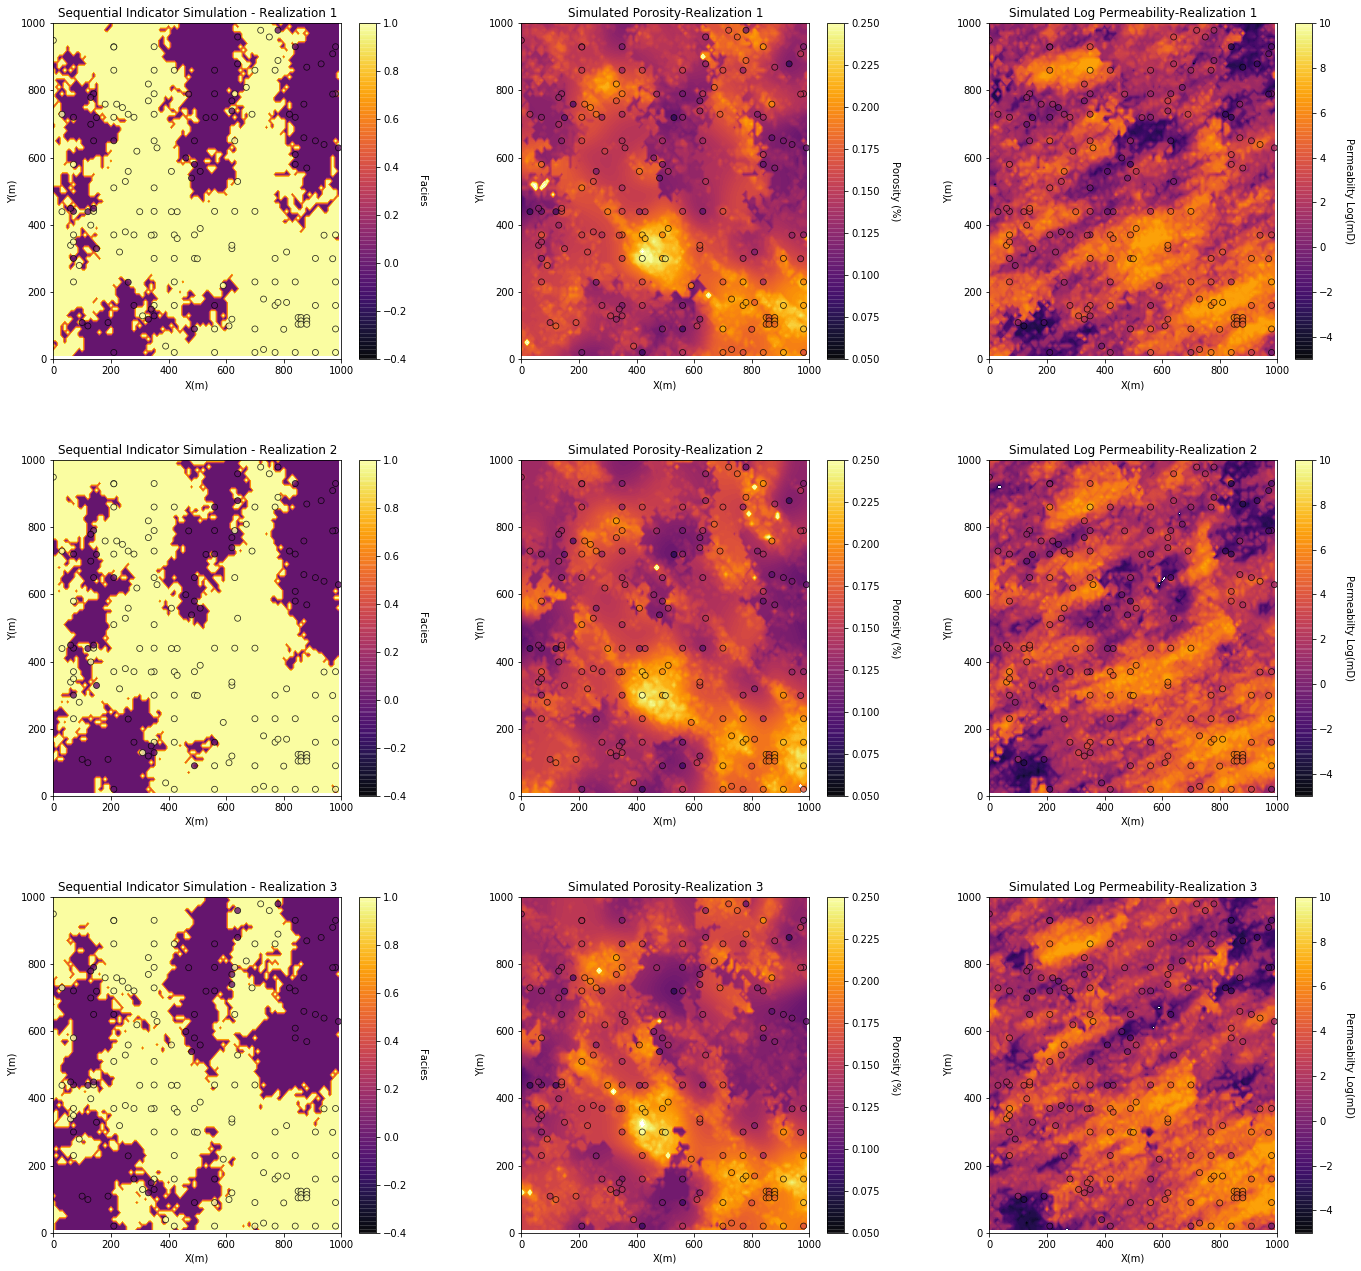

In [147]:
plt.subplot(331)
GSLIB.locpix_st(sim_ik[0],xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 1','X(m)','Y(m)','Facies',cmap)
plt.subplot(332)
GSLIB.locpix_st(por_sim[0],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Simulated Porosity-Realization 1','X(m)','Y(m)','Porosity (%)',cmap)
plt.subplot(333)
GSLIB.locpix_st(log_perm_sim[0],xmin,xmax,ymin,ymax,xsiz,-5.0,10,df,'X','Y','logPerm','Simulated Log Permeability-Realization 1','X(m)','Y(m)','Permeabilty Log(mD)',cmap)

plt.subplot(334)
GSLIB.locpix_st(sim_ik[1],xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 2','X(m)','Y(m)','Facies',cmap)
plt.subplot(335)
GSLIB.locpix_st(por_sim[1],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Simulated Porosity-Realization 2','X(m)','Y(m)','Porosity (%)',cmap)
plt.subplot(336)
GSLIB.locpix_st(log_perm_sim[1],xmin,xmax,ymin,ymax,xsiz,-5.0,10,df,'X','Y','logPerm','Simulated Log Permeability-Realization 2','X(m)','Y(m)','Permeabilty Log(mD)',cmap)

plt.subplot(337)
GSLIB.locpix_st(sim_ik[2],xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 3','X(m)','Y(m)','Facies',cmap)
plt.subplot(338)
GSLIB.locpix_st(por_sim[2],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Simulated Porosity-Realization 3','X(m)','Y(m)','Porosity (%)',cmap)
plt.subplot(339)
GSLIB.locpix_st(log_perm_sim[2],xmin,xmax,ymin,ymax,xsiz,-5.0,10,df,'X','Y','logPerm','Simulated Log Permeability-Realization 3','X(m)','Y(m)','Permeabilty Log(mD)',cmap)


plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=4.2, wspace=0.3, hspace=0.3)
plt.show()